<h1> Twitter Sentiment Analysis Covid-19 </h1>

In [ ]:

from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
import re
import json

# Enter Twitter API Keys
consumer_key='Confidential'
consumer_secret='Confidential'
access_token='Confidential'
access_secret='Confidential'

# Create tracklist with the words that will be searched for
tracklist = ['#coronavirus', '#covid-19', '#covid','#covid19','#corona']
# Initialize Global variable
tweet_count = 0
# Input number of tweets to be downloaded
n_tweets =20000

# Create the class that will handle the tweet stream
class StdOutListener(StreamListener):
      
    def on_data(self, data):
        global tweet_count
        global n_tweets
        global stream
        all_data=[]
        
             
        if tweet_count < n_tweets:
            print(data)
            #all_data = json.loads(data)
            with open('tweets.json', 'a') as f:
                f.write(data)
                
           
            
             
            
            
            tweet_count += 1
            
        
   
            
            return True
        else:
            stream.disconnect()
    

    def on_error(self, status):
        print(status)



# Handles Twitter authetification and the connection to Twitter Streaming API
l = StdOutListener()
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
stream = Stream(auth, l)
stream.filter(track=tracklist,languages=["en"])



In [1]:
import json
import pandas as pd
tweets_data_path = "tweets.json"  
tweets_data = []  
tweets_file = open(tweets_data_path, "r")  
for line in tweets_file:  
    try:  
        tweet = json.loads(line)  
        tweets_data.append(tweet)  
    except:  
        continue
tweets = pd.DataFrame()
tweets['text'] = list(map(lambda tweet: tweet['text'], tweets_data))
tweets['Username'] = list(map(lambda tweet: tweet['user']['screen_name'], tweets_data))
tweets['location'] = list(map(lambda tweet: tweet['user']['location'], tweets_data))
tweets['Timestamp'] = list(map(lambda tweet: tweet['created_at'], tweets_data))
tweets['followers'] = list(map(lambda tweet: tweet['user']['followers_count'], tweets_data))




tweets.head(5)

,text,Username,location,Timestamp,followers
0,"RT @DarranMarshall: 🦠 NEW DAILY RECORD\n\n+1,2...",BalmitgereA,France éternelle,Fri Oct 16 13:31:11 +0000 2020,993
1,21 hospitals are now been treated for #coronav...,anp66,"Colombo , Sri Lanka",Fri Oct 16 13:31:12 +0000 2020,1211
2,RT @DavidCornDC: “We’re doing fine.”\n — Do...,MorrisMichaelB,None,Fri Oct 16 13:31:12 +0000 2020,198
3,#COVID19patients put #remotecare to the test h...,Slabodkin,None,Fri Oct 16 13:31:12 +0000 2020,2275
4,RT @ericswalwell: Ben Sasse remains the Mitt R...,cindyceemerson,Minnesota,Fri Oct 16 13:31:12 +0000 2020,2939


In [2]:
len(tweets)


167170

<h1>Extract Country from location </h1>

In [ ]:
import googlemaps
googleapikey='Confidential'
gmaps = googlemaps.Client(key=googleapikey)
geocode_result = gmaps.geocode(tweets['location'][1])

print(geocode_result)

In [80]:
print(geocode_result[0]['formatted_address'])

print(geocode_result[0]['formatted_address'].split(",")[-1].strip())

Virginia, USA
USA


In [81]:
def get_country(input):
    try:
        
        output=gmaps.geocode(input)[0]['formatted_address'].split(",")[-1].strip()
    except:
        output="other"
    return output

In [82]:
tweets['country']=tweets['location'].apply(lambda x: "" if (not x.strip()) else get_country(x))

In [83]:
import matplotlib.pyplot as plt
tweets['country'].value_counts()

tweets['Country'].value_counts().head(30).plot(kind='barh', figsize=(20,10))

USA                22270
India               7049
UK                  5819
other               4743
Canada              3433
                   ...  
The Great Lakes        1
1840 Luxembourg        1
1027 Hungary           1
Western Europe         1
Korea                  1
Name: country, Length: 343, dtype: int64

In [10]:
tweets.head()

,text,Username,location,Timestamp,followers
0,"RT @DarranMarshall: 🦠 NEW DAILY RECORD\n\n+1,2...",BalmitgereA,France éternelle,Fri Oct 16 13:31:11 +0000 2020,993
1,21 hospitals are now been treated for #coronav...,anp66,"Colombo , Sri Lanka",Fri Oct 16 13:31:12 +0000 2020,1211
2,RT @DavidCornDC: “We’re doing fine.”\n — Do...,MorrisMichaelB,None,Fri Oct 16 13:31:12 +0000 2020,198
3,#COVID19patients put #remotecare to the test h...,Slabodkin,None,Fri Oct 16 13:31:12 +0000 2020,2275
4,RT @ericswalwell: Ben Sasse remains the Mitt R...,cindyceemerson,Minnesota,Fri Oct 16 13:31:12 +0000 2020,2939


<h1>Extract Date </h1>

In [121]:
tweets['date']=pd.to_datetime(tweets['Timestamp']).dt.date

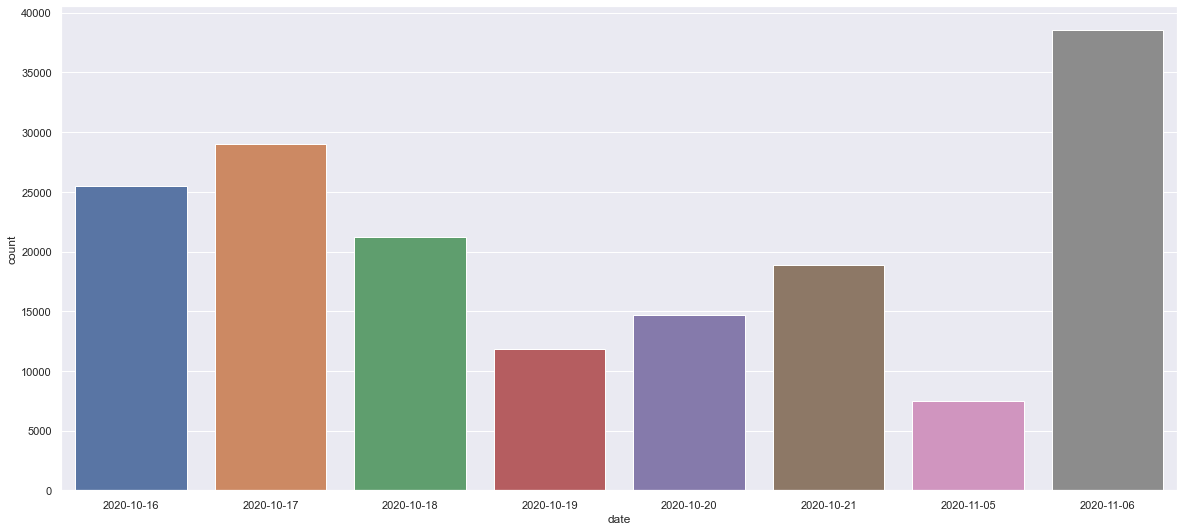

In [150]:
import seaborn as sns
sns.countplot(x="date", data=tweets)
sns.set(rc={'figure.figsize':(20,8.27)})

 <h1> text Preprocessing </h1>

In [3]:
import re

def clean_tweets(text):
    import string 
    from string import digits
    remove_digits = str.maketrans('', '', digits)
    text=text.translate(str.maketrans('', '', string.punctuation))#removing all ponctuations
    text =text.translate(remove_digits)
    text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
    text = re.sub("@[\w]*","",text)# removed @mention
   
    text = re.sub("RT @[\w]*:","",text)#removing rt
    text = re.sub('RT[\s]+', '', text) # Removing RT
   
    
    
    text=re.sub("[^\w\s#@/:%.,_-]", "", text, flags=re.UNICODE)#remove emoji
    
    text = text.replace('x', '')
    text=re.sub(r'https?:\/\/\s+','',text)#remove the hyper link
    text=re.sub("http\\w+", "",text)
    
    #text = re.sub("https?://[A-Za-z0-9./]*","",text)
    
    text=re.sub(r'^[A-Za-z0-9.!?]+'," ",text) ##Removing digits and punctuations
    text=re.sub(r'#','',text)# removing hachtag
    text=re.sub(r' +'," ",text)
    text = re.sub("\n","",text)
    text = text.lower()
   
    
    
    text = re.sub("^\\s+|\\s+$", "", text)  # Remove leading and trailing white space
    
   

    return text

In [4]:
tweets['text']=tweets['text'].apply(clean_tweets)


In [5]:
tweets['text'].tail(10)

167160    breakingus sets a new utterly insane record of...
167161    florida has a surging coronavirus health crisi...
167162    do you all understand what k cases of covid ep...
167163    any obvious errors or omissions please let me ...
167164    he suppressed his own vote sums it up nicelyan...
167165    school covid eposure alert ron brent elementar...
167166    coronavirusindia a rising number of students a...
167167    despite many global challenges this is what th...
167168    get your hopes up that theres an overthecounte...
167169    we are giving person a ps or their choice of c...
Name: text, dtype: object

<h1>Contraction to Expansion</h1>

In [6]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not ",
"can't": "cannot",
"can't've": "cannot have",
"cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is ",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [7]:
def cont_to_exp(txt):
    if type(txt) is str:
        for key in contractions:
            value = contractions[key]
            txt = txt.replace(key, value)
        return txt
    else:
        return txt

In [8]:
tweets['text']= tweets['text'].apply(lambda x: cont_to_exp(x))

In [561]:
#tweets['text']= tweets['text'].apply(lambda x: " ".join(x.split())) #Remove multiple spaces 

<h1>remove all emoji </h1>

In [9]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [10]:
tweets['text']= tweets['text'].apply(lambda x: remove_emoji(x))

In [12]:
tweets.tail(5)

,text,Username,location,Timestamp,followers
167165,school covid eposure alert ron brent elementar...,BcExfiles,BC,Fri Nov 06 05:02:59 +0000 2020,207
167166,coronavirusindia a rising number of students a...,ChristianHeist2,Switzerland,Fri Nov 06 05:02:59 +0000 2020,380
167167,despite many global challenges this is what th...,Neetwit,Colombo,Fri Nov 06 05:03:00 +0000 2020,2768
167168,get your hopes up that theres an overthecounte...,DigitalisMedica,Arizona,Fri Nov 06 05:03:01 +0000 2020,13
167169,we are giving person a ps or their choice of c...,MoritLf,None,Fri Nov 06 05:03:01 +0000 2020,2


In [13]:
print('Total tweets in this data: {}'.format(tweets.shape[0]))
print('Total Unique Users in this data: {}'.format(tweets['Username'].nunique()))

Total tweets in this data: 167170
Total Unique Users in this data: 121267


<h1> function to get the subjectivity </h1>

In [14]:

#Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information.
#Subjectivity is also a float which lies in the range of [0,1]
from textblob import TextBlob
from wordcloud import WordCloud
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity


<h1>function to get the polarity</h1>

In [15]:

#Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement
def getPolarity(text):
     return TextBlob(text).sentiment.polarity

In [16]:
#create two columns
tweets['Subjectivity']=tweets['text'].apply(getSubjectivity)
tweets['Polarity']=tweets['text'].apply(getPolarity)

In [17]:
tweets.head()

,text,Username,location,Timestamp,followers,Subjectivity,Polarity
0,new daily record new cases of covid in n irela...,BalmitgereA,France éternelle,Fri Oct 16 13:31:11 +0000 2020,993,0.306061,0.048485
1,hospitals are now been treated for coronavirus...,anp66,"Colombo , Sri Lanka",Fri Oct 16 13:31:12 +0000 2020,1211,0.000000,0.000000
2,were doing fine donald trump,MorrisMichaelB,None,Fri Oct 16 13:31:12 +0000 2020,198,0.500000,0.416667
3,put remotecare to the test telemedicine telehe...,Slabodkin,None,Fri Oct 16 13:31:12 +0000 2020,2275,0.000000,0.000000
4,ben sasse remains the mitt romney of susan col...,cindyceemerson,Minnesota,Fri Oct 16 13:31:12 +0000 2020,2939,0.500000,0.116667


<h1>word cloud </h1>

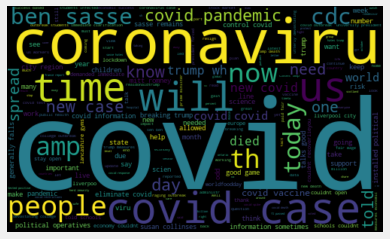

In [41]:

#Word Cloud is a data visualization technique 
#used for representing text data in which the size of each word indicates its frequency or importance.
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
allWords=' '.join([tweets for tweets in tweets['text']])
wordcloud=WordCloud(width=500,height=300,random_state=21,max_font_size=300).generate(allWords)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

<h1> create a function to compute positive , negative and neutral analysis </h1>

In [18]:

def getAnalysis(score):
    if score<0:
        return 'Negative'
    if score==0:
        return 'Neutral'
    else:
        return 'Positive'

In [19]:
tweets['Analysis'] =tweets['Polarity'].apply(getAnalysis)


In [20]:
def transform(text):
    if (text=='Positive'):
        return 2
    elif (text=='Neutral'):
        return 1
    else :
        return 0

In [21]:
tweets['label']=tweets['Analysis'].apply(transform)


In [27]:
tweets.head()

,text,Username,location,Timestamp,followers,Subjectivity,Polarity,Analysis,label
0,new daily record new cases of covid in n irela...,BalmitgereA,France éternelle,Fri Oct 16 13:31:11 +0000 2020,993,0.306061,0.048485,Positive,2
1,hospitals are now been treated for coronavirus...,anp66,"Colombo , Sri Lanka",Fri Oct 16 13:31:12 +0000 2020,1211,0.000000,0.000000,Neutral,1
2,were doing fine donald trump,MorrisMichaelB,None,Fri Oct 16 13:31:12 +0000 2020,198,0.500000,0.416667,Positive,2
3,put remotecare to the test telemedicine telehe...,Slabodkin,None,Fri Oct 16 13:31:12 +0000 2020,2275,0.000000,0.000000,Neutral,1
4,ben sasse remains the mitt romney of susan col...,cindyceemerson,Minnesota,Fri Oct 16 13:31:12 +0000 2020,2939,0.500000,0.116667,Positive,2


In [118]:
#print all of Negative tweets
j=1
Sortedtweets=tweets.sort_values(by='Polarity')
for i in range(0,Sortedtweets.shape[0]):
    if(Sortedtweets['Analysis'][i]=='Negative'):
        print(str(j)+')'+Sortedtweets['text'][i]+'\n')
        
        j+=1

1)is the type of person who should guide the nation through the real heartache and grief being caused by…

2)the fuck is going on

3)solving the climatecrisis too epensive think again covid recovery stimulus dwarfs green energy investment needs…

4)when you see the lungs of young adults in their ’s and ’s shutting down from covid despite all treatment you realize t…

5)issues of vulnerable groups are taken up by policymakers only when they are convenient vandriukaitis gasteinforum nobodyl…

6)factsmatter lockdowns are a luury of the rich it is the working class and the poor whose lives are destroyed by prolo…

7)issues of vulnerable groups are taken up by policymakers only when they are convenient vandriukaitis gasteinforum nobodyl…

8)given the underreporting rate of covid deaths we have certainly topped by now this is so horrible heinou…

9)an ehausted socialcare sector dealing with the secondwave of covid this is immensely depressing news…

10)because it isn’t an issue for your anie

608)unfortunately in this world who lives or dies is directly related to money covid voteblue onev bidenharris bek…

609)the croatian region of istria the only region in europe coloured green on the map covid istria croatia …

610)being sent home yesterday with an illness browns wide receiver odell beckham jr’s covid test came back n…

611)wide open us we are net winter is coming covid lockdown europe reimposes painful curbs as infe…

612)these doctors urge all doctors to stop using the covid pcr test due to now to false positives …

613)who is advisimg nphet on mental health nphet

614)covid has changed it all for us doctors those of us who are suffering from covid and its aftermath are in trouble and th…

615)we are being lied to on an epic scalethis is the largest psyop in historythe numbers are fake the tests are bullshit…

616)american souls lost due to trump and republicans inaction during the covid pandemic chipotletweets leader…

617)you may be eligible for the new canada recov

1181)the pm or possibly the man behind him pulling strings tell us what australia style deal actually is…

1182)who ccp order labs to destroy the coronavirus sample sacrifice people of the world to protect thei…

1183)this is a profoundly undemocratic amp dangerous power grab by the government which will delegitimise the measures introduc…

1184)scaramucci dcano thursday turds of dopeydonsupports ca gop illegal ballot boesm jobs lost since trump took…

1185)on one hand we are being told absolutely no let up in safety precautions untill vaccinemedicine for covidon the oth…

1186)on air now brentbeaird joins harponsports to preview this weekends sec matchups and look at gregsankeys covid…

1187)guthrie when was your last negative coronavirus testtrump well i test quite a bitg did you test the day of th…

1188)actually trump almost killed christie with eposing fatty to covid so it might be personal with him

1189)these doctors urge all doctors to stop using the covid pcr test due to now t


1786)senrickscott who ccp order labs to destroy the coronavirus sample sacrifice people of the world to protect their re…

1787)when you see the lungs of young adults in their ’s and ’s shutting down from covid despite all treatment you realize t…

1788)we showed in this paper that masks can create far worse diseases than covid

1789)ive spent the past few months talking to farmworker women about their struggles finding childcare amid covidwith sc…

1790)cdc almost all children who died from covid were hispanic or black lt black people trump is not investing …

1791)early voting in florida starts on monday mail in and absentee ballots have already been mailed if you are fearful of votin…

1792)about the same amount he answers ridiculous covid questions

1793)queens sport is working hard to ensure that we continue to deliver our programme of sport and physical activity following…

1794)trump lied people died republicans made money typical 

1795)university president forced to resign af


2455)it would be impossible for cubans to forget that during the crisis caused by the covid pandemic the us government cho…

2456)is completely heartbreaking the situation with care funding is so broken

2457)cdc almost all children who died from covid were hispanic or black lt black people trump is not investing …

2458)following the peak of the covid outbreak earlier this year newfield nursing home saw a sharp drop in the number of residen…

2459)i fancy bojo has got his mojo back he’s not going to be fucked around any longer those with him will love him those…

2460)qanon quite a clevercultish condecries msm as commie leftist liesmobbydon whose words q rests ondenies responsi…

2461)the fbi warns that child abductors could potentially use social media to lure victims due to covidrelated school closures m…

2462)nothing illustrates the failure of the sage oneclub approach than the failure to properly utilise another weapon in the war…

2463)cdc almost all children who died from covi


2740)worst is yet to come

2741)the only person who should not wear a mask because of coronavirus is joebidenbecausehes been hiding behind the ma…

2742)sensasse it looks like youre a republican voter against trumpits not too late to make a video – …

2743)was negative so its just really shit flu covid

2744)shocks at nbc town hall by defending insane qanon conspiracists biden harris trump pence gop…

2745)belief out there that the coldchain and refrigeration is the single mostimportant factor in coronavirus…

2746)animals have done nothing to us to be paying the price in this violent society this is simply human trashleave ani…

2747)are about months into the globalpandemic i have not actively stayedhome i remain negative for covid an…

2748)in this covid situation in person treatment is difficult find out about how telehealth can help to recover from addict…

2749)what is this canadian whistleblower all about covid concentrationcamps and why was his mic closed when asked the que…

2


3227)this is completely the issue as roinnslainte try and hide behind covid as the problemi think we all realise that we…

3228)calderdale royal hospital aampe are facing increasing pressure due to covidby going to aampe when you don’t need to you…

3229)due to the impact of covid we’re unable to deliver the full waste collection servicefrom monday october gre…

3230)the rich have just got richer in covid but democratic politicians across the us are inflicting vicious austerity on worke…

3231)russia starts testing sputnik v covid vaccine on volunteers aged over

3232)realdonaldtrump erin thomassens son from florida sick from covid but lived “i thumbed my nose at eperts amp my lit…

3233)my question to borison rd sept the deputy pm said that the covid test was false positivewhy are you basing…

3234)in the midst of the sweeping socioeconomic devastation wrought by covid restrictions one field sadly is booming m…

3235)in just few days added deaths dead from trumps inept covid response


3856)realdonaldtrump erin thomassens son from florida sick from covid but lived “i thumbed my nose at eperts amp my lit…

3857)imagine this malta has been doing very badly re covid nation is scared friday evening prime minister set…

3858)tiny owls application for acenational emergency funding has been rejected this is disappointing news how can smal…

3859)we miss you look back at ourtimes together at the kimballsenior center nationalcity sandiego ca cov…

3860)covid restrictions are especially hard on teens serious danger signs are isolation in room unusual sleeping patterns…

3861)covid has had a devastating impact on poor communities and corona virus epert peter hotez presents an important call t…

3862)covid restrictions are especially hard on teens serious danger signs are isolation in room unusual sleeping patterns…

3863)ever wondered what the meaning behind is wonder no more this is a must read article…

3864)university president forced to resign after utterly devastating col


4396)ubercute video collab by babyshark pinkfong amp seoulgov to thank citizens of seoul who have been actively taking part in…

4397)yee hong markham centre resident dies due to covid coronavirus

4398)i blametrump for all the fear and loathing in the united states over the last four years i blame trump for the tragic cov…

4399)military reports active covid cases in the ranks coronavirus covid…

4400)realdonaldtrump blametrump  plus lies highest coronavirus cases worldwide  dead from covid still…

4401)the covid pandemic the pacific aid map data reveals the limited support aid has played in the healt…

4402)cant get out of the house because of the coronavirus go to ancient japan instead ride a unicorn and fight evil warlords…

4403)herdimmunity without protection from the virus is dangerous and immoral covid

4404)is this going to be the year where ill be celebrating deepavali all alone

4405)of us have not died of covid of the tests are false positive to base lockdown on number of 


5124)herdimmunity without protection from the virus is dangerous and immoral covid

5125)i miss the days where the number of cases are less than instead of epecting new record number of cases every few days

5126)it would be impossible for cubans to forget that during the crisis caused by the covid pandemic the us government cho…

5127)rishisunak a few weeks ago you gave us eat out to help out literally encouraging people to eat in…

5128)is actually very bad sabahs hospitals are almost at ma capacity if this keeps going down theres gonna be…

5129)i miss the days where the number of cases are less than instead of epecting new record number of cases every few days

5130)only new case down from two months ago well done victoria amp victorians covid

5131) why is india so vulnerable to cyberattackscovid cyberattacks cybersecurity pandemic securitythreats…

5132)without confirmation imo are terrible causing untold aniety and stress while we are all waiting in limbo to…

5133)herdimmunity

5591)i miss the days where the number of cases are less than instead of epecting new record number of cases every few days

5592)they were trialling a minute covid test at heathrow yesterday results sent via tet and email this could be a game change…

5593)i miss the days where the number of cases are less than instead of epecting new record number of cases every few days

5594)here we go the case count creep is heading up again in georgia took a little longer but i think it’s a lag in the numbers y…

5595)dead per week and still a media black out that aviptadil has proven to cure of sickest people and no study…

5596)fydsy jacindaardern is that a poster behind her if not where are the facemaskscovid

5597)nine deaths in one dayi worry we are becoming a bit numb about the people who are dying from this virusa plea to jou…

5598)mayor of liverpool joe anderson mayoranderson has confirmed his brother has sadly died in hospital after bei…

5599)oldfirm game i haven’t been in the stand for


6199)millions of people are trapped in etreme poverty around the world the covid pandemic could further eacerbate their suffering…

6200)pm justintrudeau sends a heartfelt message to children across canada about difficult times saying we all need to d…

6201)the situation in europe looks grim but there is also hopedespite being surrounded by countries with a high incidence ge…

6202)herdimmunity without protection from the virus is dangerous and immoral covid

6203)new painful colorofcoronavirus data• in black • in indigenous • in latino• in pac…

6204)has epanded the number of uninsured amp is creating new vulnerabilities for the working poor medicaid must…

6205)breaking newsslovenia liubijana coronavirusslovenia is giving up corona contact tracking due to overload the coun…

6206)qanon quite a clevercultish condecries msm as commie leftist liesmobbydon whose words q rests ondenies responsi…

6207)while mo gop politicians look the other way patting themselves on the back and our sta


6835)late trip to asda the bame lot can stop fucking whining about being more susceptible to covid majority o…

6836)im shocked this man has any sort of podium hes wrong so many times top us doctor unloads on crazy dr fauci plus fauc…

6837)has killed around million people and you are still alive today use few seconds and thank god for gift o…

6838)atlas has a long long history of telling false covid info he previously claimed he never advised opening schools t…

6839)millions of people are trapped in etreme poverty around the world the covid pandemic could further eacerbate their suffering…

6840)in every single statistic the american covid crisis is going the wrong way were heading into a damned death spira…

6841)protesters storm abuja defying police and military crackdown and a ban by the fct authorities over covid the protester…

6842)i never really likedsupported trump movement has already started no honor among thieves just like they d…

6843)here is atlas further doubling dow


7518)erictrump he sold that house years ago you twit a home he bought in for less thank less dollars than deat…

7519)covid tests were done today and it was a steady flow of traffic unfortunately some people were turned away at the…

7520)the fuck is my leasing company having strangers come into my fucking home to look in my toilet rifle through m…

7521)on wednesday morning a statement was released by the military which stated that the troops have been given the option to…

7522)if you’ve doubted that covid is back big style think again my share of the resp ward round atoday took hou…

7523)the global economy is recovering from the covid pandemic but the long ascent back to growth is uneven and uncertain find o…

7524)a divided world has failed to rise to the challenge of fighting the coronavirus pandemic says un chief guterres warn…

7525)so while the media is trying to make fetch happen with hunter biden youve got this shit

7526)covid cases in canada per manitoba quebec alberta ca

8188)sad to hear this news tinyowlbooks clearly the wrong decision has been taken by acenational the books yo…

8189)is another ugly reality of covid that can not be ignored no matter how much those that have it wis…

8190)jesus michealmartintd leovaradkar cmoireland please lock us down from people working in residential care s…

8191)herdimmunity without protection from the virus is dangerous and immoral covid

8192)realdonaldtrump oh god ronna it’s the panic buying starting up again you idiot may be instead…

8193)just seen skynews care home peace newfield all residents apart from dead from coviduk the business has gone amp all sta…

8194)eugenics can be passivelike depriving poor people of prevention care and treatment covid ge…

8195)we were blessed to have the choice to stay open says bunanue of goyafoods he says state governments are actively harmin…

8196)indianarmy distributed covid kits containing facemasks hand sanitizers hand wash amp hand gloves at remote kontwara…

8197)wh


8927)due to covid aka coronavirus ill be sending the first people to like amp retweet this through cashapp…

8928)just watched a guy pull down his mask to pick his nosecovid will be in the us forever

8929)government sorry the only solution now is a to week lockdown choose now save lives follow the bloody s…

8930)tracking coronavirus cases amp deaths at least people have died from covid in the usamp least cases…

8931)not a single woman here to make the enormous decision this afternoon on whether we shut down the country again or notutter…

8932)fear sadness grief loneliness frustration irritability — all are normal responses to the pandemic the increased ra…

8933)zakiyachinyere icecube ava kingjames plies unclelukereal hey will this virus destroy the economy…

8934)dear danielandrewsmpim from nsw you have led your state during the black summer bushfires amp now during this covid…

8935)herdimmunity without protection from the virus is dangerous and immoral covid

8936)this letter i

9613)islands with tour boats moored due to the coronavirus pandemic the animals are out…

9614)realdonaldtrump the biden family and ccps corrupt interpersonal logic chart chinesewhistleblower…

9615)ontario residentsweve been frustrated w the lack of transparency amp communication from fordnation on covid deci…

9616)what was the infectiondeath rate of people living in nursing homes that were forced to take in…

9617)said the head of the coronavirus task force as of today there are m cases and k dead from covid

9618)said the head of the coronavirus task force as of today there are m cases and k dead from covid

9619)if you think it’s bad for tourists imagine how the actual citizens of ireland feel also aren’t y’all literall…

9620)“freedomdoes not include the freedom to get someone else sick it does not include the freedom tosneeze on someon…

9621)realdonaldtrump according to donald trump if you don’t take a test you’re not pregnant that must be why he was lying…

9622)pcr testing is


10022)breaking—a man arrested after allegedly threatening to kidnap the mayor of wichita kansas over the citys covid public…

10023)x you are just politicians all you guys are worried about is being in power then blame each other

10024)this is so etremely well done and i’m a sucker for proper scansion in parody songs

10025)coronaupdate etended mandatory maskwearing for students teachers and all other attendees wearing a mask is mandator…

10026)wedding with attendees shut down amid covid satmarhq needs to invite antifa a…

10027)coronavirus empty streets in france as curfew enforcedcorona

10028)twitter hides a tweet of potus coronavirus advisor swatlashoover for violating rules against sharing false and harmful inf…

10029)napsandsarcasm mjosling selfish unintelligent jack wads covidspot on 

10030)read the study disturbing in a young lowrisk population wongoing symptoms almost of individuals have imp…

10031)napsandsarcasm mjosling selfish unintelligent jack wads covidspot on 

10

10619)“freedomdoes not include the freedom to get someone else sick it does not include the freedom tosneeze on someon…

10620)el presidente is leaving a trail of covid outbreaks behind him you could track his campaign stops by tracking covi…

10621)if you think that vaccine ability to make a disease worse is something made up by antivaers listen to dr fauci talking…

10622)doubled their trade receivables from crore q to crore q mainly due to covid

10623)ontario residentsweve been frustrated w the lack of transparency amp communication from fordnation on covid deci…

10624)“we should have stopped this a long time ago” dr larrybrilliant says about covid in the us “if of americans wea…

10625)a few people have tweeted asking about my comment on crosstalk that black men and women are dying of covid at a h…

10626)if you are young and healthy covid can be dangerous or even deadly dont take a chance wearamask and st…

10627)another gop covid superspreader what could go wrong trumpliedkdied

11201)as we approach souls lost to the coronavirus it’s tragic that the president and mitch mcconnell have yet to get s…

11202)im really sick of information that we all need clarity on being commandeered by simon harris just to get his face in fro…

11203)breaking—a man arrested after allegedly threatening to kidnap the mayor of wichita kansas over the citys covid public…

11204)as we approach souls lost to the coronavirus it’s tragic that the president and mitch mcconnell have yet to get s…

11205)as we approach souls lost to the coronavirus it’s tragic that the president and mitch mcconnell have yet to get s…

11206)wrong orderthere was no evidence that covid could not be transmitted prior to people having symptoms hence the need…

11207)like and surprise in dm bored covid blonde snapchat nyc myfirsttweet newprofilepic

11208)hypocrite chriscuomo receives a warning to wear a mask at park avenue in nyc amp putting other residents amp staff…

11209)is a sick restructuring of our socie

11810)the united states has the worst response in the world to covid because we have the worst president trumps campaigning…

11811)please look under the hood of this baby there is something truly evil in play and it has nothing t…

11812)chinas economy grew in the third quarter consumer spending supposed to drive growth these days was weak beijin…

11813)victoriaderbyshirelast year serco was found guilty of defrauding the govt over numbers of prisoners they said theyd tagg…

11814)the united states has the worst response in the world to covid because we have the worst president trumps campaigning…

11815)lawmakers pen letter to lightfoot cps asking for remote learning improvements stronger safety measures before return…

11816)think about the time i posted this poll semioften we really had no idea how bad it was the president did tho…

11817)the united states has the worst response in the world to covid because we have the worst president trumps campaigning…

11818)breaking global cov


12359)of all the ways realdonaldtrump mishandled his covid illness the worst is what he’s doing nowits not just the supe…

12360)and the ecess deaths in private homes are mostly not covid

12361)a brief terrifying history of viruses escaping from labs s chinese pandemic was a lab mistakethe danger of a ma…

12362)insiders were interviewed by washingtonpost to produce this horrifying stark acct of the inner workings of the wh…

12363)im not sure what is worse people thinking it will only be weeks or the ones who think it will actually make any di…

12364)some people wait longer for covid test results finds this national survey what do delays mean for contacttracing …

12365)i admire the firm commitment of the scientific community to follow the truth wherever the facts may lead unless those facts…

12366)trump’s disastrous leadership has covid hospitalizations on the rise coronavirus hospitalizations are increasing i…

12367)testing delays still far too long to help contain covid‘the av

13038)will covid destroy our halloween this year too       are you guys…

13039)covid has thrown a serious challenge on blood donation front still just tag blooddonorsin in this difficult time bo…

13040)yesterday a repair man came to my house refused to wear a mask and informed me covid is not real i did not let him…

13041)its unfortunate it took a court order for govwhitmer to work with the legislature but doing so will finally bring an end t…

13042)‘it’s very strange’ says jones as priority collins’ covid test result delayed …

13043)breaking global covid cases surpassed million the americas account for about half of cases us leads with m…

13044)twitter is suffering from something much worst than covid

13045)this is what lockdowns look likepeople do not go to hospitals even for serious conditions like stroke and heart attack…

13046)coronavirus cases rise fauci says public health measures are the way to slow spread abc…

13047)doctor assam must be a difficult place to work too



<h1>plot the polarity and subjectivity</h1>

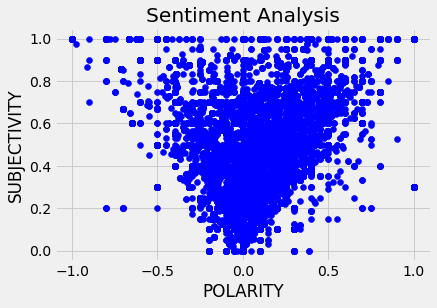

In [50]:


for i in range(0,tweets.shape[0]):
    
    plt.scatter(tweets['Polarity'][i],tweets['Subjectivity'][i],color='Blue')
plt.title('Sentiment Analysis')
plt.xlabel('POLARITY')
plt.ylabel('SUBJECTIVITY')
plt.show()

In [28]:
# pourcentage positive tweets 
PourcentagePos=tweets[tweets['Analysis']=='Negative']
PourcentagePos=round((len(PourcentagePos['text'])/len(tweets))*100,1)
PourcentagePos

16.9

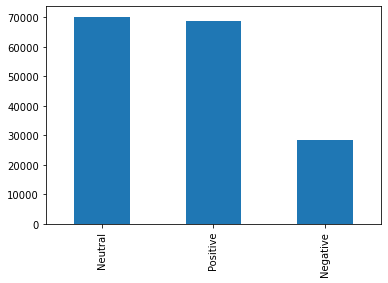

In [30]:
from matplotlib import pyplot as plt
tweets['Analysis'].value_counts().plot(kind='bar')
plt.show()

<h1>Tokenize word and sentence</h1>

In [31]:
import nltk
#nltk.download()

In [385]:
#sentences=[]
#words=[]
#for i in range(0,tweets.shape[0]):
    #sentences.extend(nltk.sent_tokenize(tweets['text'][i]))
    #words.extend(nltk.word_tokenize(tweets['text'][i]))
    

    
    




In [382]:
#for i in range(0,len(sentences)):
    #words=nltk.word_tokenize(sentences[i])
    

    

In [30]:
sentences = tweets.iloc[0]
sentences['text']

'Eye opening  More cops  have died from COVID this year than have died while on patrol  Yet Trump fuels violen…'

In [31]:
print (nltk.sent_tokenize(sentences['text']))
print('*********************************')
print (nltk.word_tokenize(sentences['text']))

['Eye opening  More cops  have died from COVID this year than have died while on patrol  Yet Trump fuels violen…']
*********************************
['Eye', 'opening', 'More', 'cops', 'have', 'died', 'from', 'COVID', 'this', 'year', 'than', 'have', 'died', 'while', 'on', 'patrol', 'Yet', 'Trump', 'fuels', 'violen…']


In [32]:
def identify_tokens(words):
    
    words=words['text']
    tokens = nltk.word_tokenize(words)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

tweets['words'] = tweets.apply(identify_tokens, axis=1)

In [33]:
def identify_tokens(sentences):
    
    sentences=sentences['text']
    tokens = nltk.sent_tokenize(sentences)
    # taken only words (not punctuation)
    
    return tokens

tweets['sentences'] = tweets.apply(identify_tokens, axis=1)

In [361]:
#convert list of sentences to string
def convert_list_to_string(text, seperator=' '):
    
  
    return seperator.join(text)
tweets['sentences']=tweets['sentences'].apply(convert_list_to_string)

<h1>Lemmatizer </h1

In [36]:

from nltk.stem import WordNetLemmatizer
w_tokenizer=nltk.tokenize.WhitespaceTokenizer()
lemmatizer=nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    
    
    return [ lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [37]:
tweets['lemmatizer_tweets']=tweets['sentences'].apply(lemmatize_text)

In [38]:
tweets.head()

,text,Username,location,Timestamp,followers,date,Subjectivity,Polarity,Analysis,label,words,sentences,lemmatizer_tweets
0,Eye opening More cops have died from COVID t...,Barbsydoll,Somewhere out there!,Tue Sep 01 18:43:36 +0000 2020,540,2020-09-01,0.500000,0.500000,Positive,4,"[Eye, opening, More, cops, have, died, from, C...",Eye opening More cops have died from COVID t...,"[Eye, opening, More, cop, have, died, from, CO..."
1,RishiSunak conhome Your promise to the nation...,TraceyInkson,None,Tue Sep 01 18:43:36 +0000 2020,11,2020-09-01,0.000000,0.000000,Neutral,2,"[RishiSunak, conhome, Your, promise, to, the, ...",RishiSunak conhome Your promise to the nation...,"[RishiSunak, conhome, Your, promise, to, the, ..."
2,With mipravindarekar felicitated doctors who a...,dhrumehtabjp13,"Mumbai, India",Tue Sep 01 18:43:36 +0000 2020,1061,2020-09-01,0.770833,-0.145833,Negative,0,"[With, mipravindarekar, felicitated, doctors, ...",With mipravindarekar felicitated doctors who a...,"[With, mipravindarekar, felicitated, doctor, w..."
3,Help find a COVID vaccine in SunderlandSign up...,MarkSundLPC,Sunderland,Tue Sep 01 18:43:36 +0000 2020,417,2020-09-01,0.000000,0.000000,Neutral,2,"[Help, find, a, COVID, vaccine, in, Sunderland...",Help find a COVID vaccine in SunderlandSign up...,"[Help, find, a, COVID, vaccine, in, Sunderland..."
4,Children are x more likely to die in an accide...,ThurstonDougK,None,Tue Sep 01 18:43:36 +0000 2020,139,2020-09-01,0.750000,0.250000,Positive,4,"[Children, are, x, more, likely, to, die, in, ...",Children are x more likely to die in an accide...,"[Children, are, x, more, likely, to, die, in, ..."


<h1>wordcloud for negative dataframe </h1>

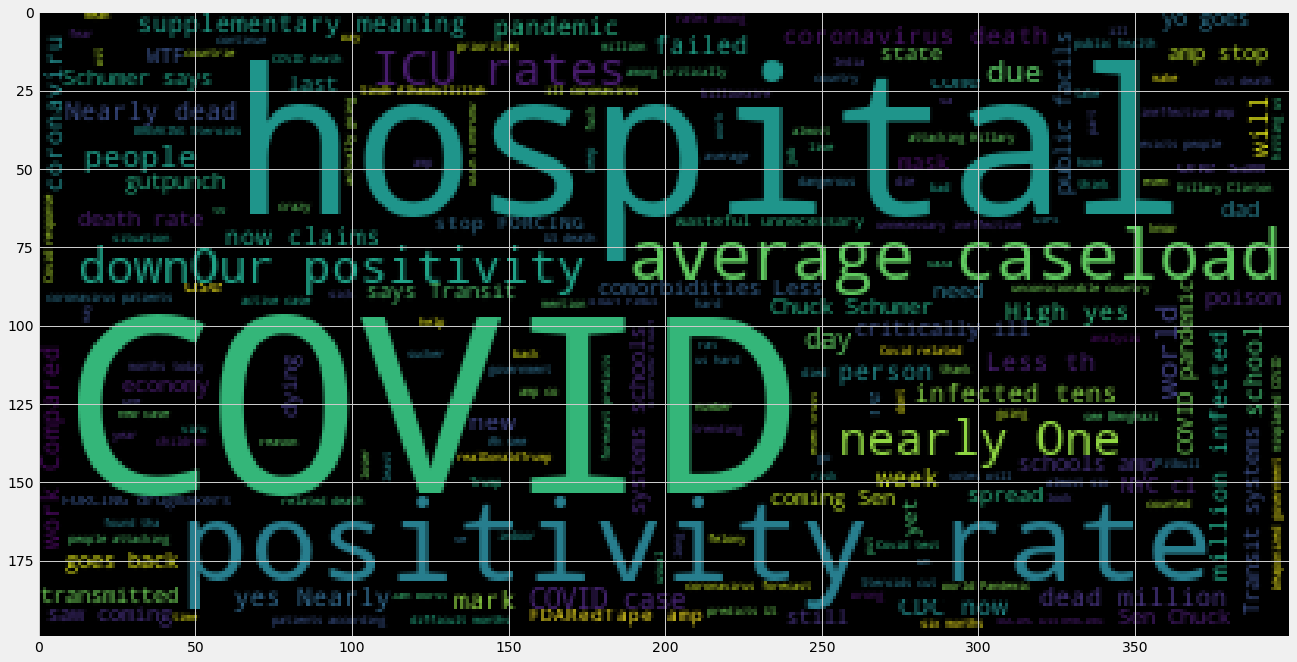

In [39]:
Negative=tweets[tweets['Analysis']=='Negative']
Negative_list=Negative['text'].to_list()
Negative_words=" ".join(Negative_list)
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(Negative_words))

<h1>wordcloud for Positive dataframe </h1>

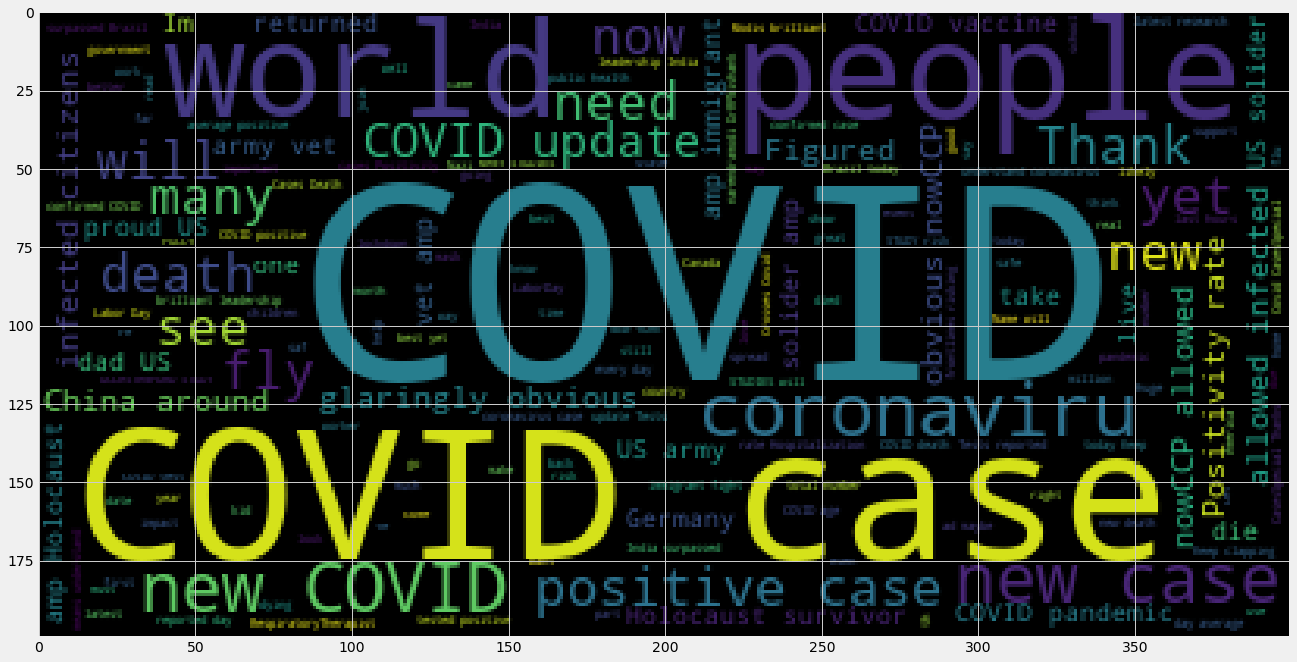

In [40]:
Positive=tweets[tweets['Analysis']=='Positive']
Positive_list=Positive['text'].to_list()
Positive_words=" ".join(Positive_list)
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(Positive_words))

<h1>Removing Stop words </h1>

In [32]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
words = set(nltk.corpus.words.words())

In [33]:

tweets['clean_tweets']=tweets['text'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))


In [35]:
tweets.head()

,text,Username,location,Timestamp,followers,Subjectivity,Polarity,Analysis,label,clean_tweets
0,new daily record new cases of covid in n irela...,BalmitgereA,France éternelle,Fri Oct 16 13:31:11 +0000 2020,993,0.306061,0.048485,Positive,2,new daily record new cases covid n ireland two...
1,hospitals are now been treated for coronavirus...,anp66,"Colombo , Sri Lanka",Fri Oct 16 13:31:12 +0000 2020,1211,0.000000,0.000000,Neutral,1,hospitals treated coronavirus patients srilank...
2,were doing fine donald trump,MorrisMichaelB,None,Fri Oct 16 13:31:12 +0000 2020,198,0.500000,0.416667,Positive,2,fine donald trump
3,put remotecare to the test telemedicine telehe...,Slabodkin,None,Fri Oct 16 13:31:12 +0000 2020,2275,0.000000,0.000000,Neutral,1,put remotecare test telemedicine telehealth vi...
4,ben sasse remains the mitt romney of susan col...,cindyceemerson,Minnesota,Fri Oct 16 13:31:12 +0000 2020,2939,0.500000,0.116667,Positive,2,ben sasse remains mitt romney susan collinses ...


<h1>Count Vectorization </h1>

In [76]:
from sklearn.feature_extraction.text import CountVectorizer

In [136]:
vectorizer=CountVectorizer()
X=vectorizer.fit_transform(tweets['clean_tweets'])

#print(vectorizer.get_feature_names())

In [137]:
y=tweets['label']
y.shape

(167170,)

In [138]:
import pickle
pickle.dump(vectorizer, open('vectorizer_covid.pkl','wb'))
loaded_vectorizer_covid = pickle.load(open('vectorizer_covid.pkl', 'rb'))

<h1> Naive Bayes </h1>

In [139]:
from sklearn.model_selection import train_test_split

In [140]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [141]:
from sklearn.naive_bayes import MultinomialNB

In [142]:
NB_classifier=MultinomialNB()
NB_classifier.fit(X_train,y_train)
y_predict=NB_classifier.predict(X_test)

In [143]:
cm=confusion_matrix(y_test,y_predict)

Text(156.5, 0.5, 'Data')

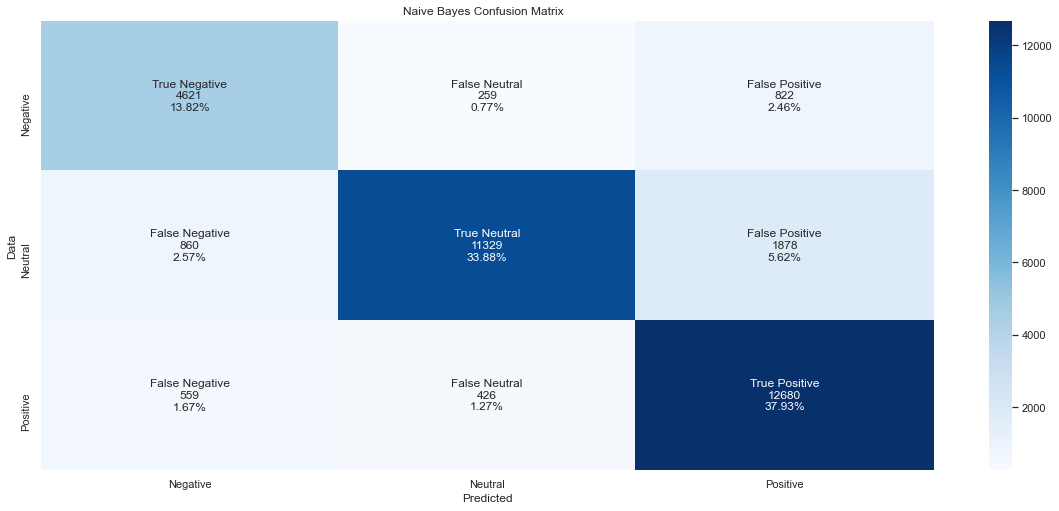

In [151]:
import seaborn as sns

group_names = ["True Negative","False Neutral","False Positive","False Negative","True Neutral","False Positive","False Negative","False Neutral","True Positive"]

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
ax= plt.subplot()
ax.set_title('Naive Bayes Confusion Matrix  ');
sns.heatmap(cm, annot=labels,ax=ax, fmt='', cmap='Blues')

ax.xaxis.set_ticklabels(['Negative','Neutral', 'Positive']); ax.yaxis.set_ticklabels(['Negative','Neutral', 'Positive']);

plt.xlabel('Predicted')
plt.ylabel('Data')

In [85]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
target_names=['Negative','Neutral' ,'Positive']
Classification_report = classification_report(y_test,y_predict, target_names=target_names)

print(Classification_report)

              precision    recall  f1-score   support

    Negative       0.77      0.80      0.79      5739
     Neutral       0.94      0.82      0.87     14008
    Positive       0.83      0.93      0.87     13687

    accuracy                           0.86     33434
   macro avg       0.85      0.85      0.85     33434
weighted avg       0.87      0.86      0.86     33434



In [87]:
from sklearn.metrics import r2_score
accuracy=NB_classifier.score(X_test,y_test)
print('accuracy',int(round(accuracy*100)),'%')
print('Coefficient of determination: %.2f'
     % r2_score(y_test,y_predict))

accuracy 86 %
Coefficient of determination: 0.49


In [47]:
from joblib import dump, load
import pickle
pickle.dump(NB_classifier, open('tweets.pkl','wb'))
model1 = pickle.load(open('tweets.pkl','rb'))

In [128]:
tweets.to_csv('tweetsproject_covid_final.csv')

In [88]:
import numpy as np 
model1 = load('tweets.pkl') 
message='the virus corona is too deadly'
data=[message]
vect = vectorizer.transform(data)
my_prediction = model1.predict(vect)
if (my_prediction[0]==2):
    print('Neutral')
elif ((my_prediction[0]==0)):
    print('Negative')
else:
    print('Positive')



Negative


<h1>SVM</h1>

In [53]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [54]:
y_prediction=svc.predict(X_test)


In [ ]:
cm=confusion_matrix(y_test,y_predict)

Text(33.0, 0.5, 'Data')

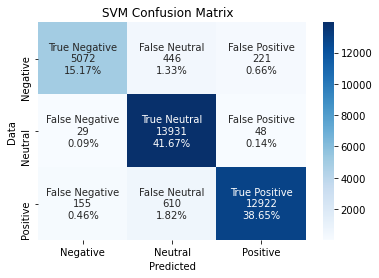

In [72]:
import seaborn as sns
group_names = ["True Negative","False Neutral","False Positive","False Negative","True Neutral","False Positive","False Negative","False Neutral","True Positive"]

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
ax= plt.subplot()
ax.set_title('SVM Confusion Matrix  ');
sns.heatmap(cm, annot=labels,ax=ax, fmt='', cmap='Blues')

ax.xaxis.set_ticklabels(['Negative','Neutral', 'Positive']); ax.yaxis.set_ticklabels(['Negative','Neutral', 'Positive']);

plt.xlabel('Predicted')
plt.ylabel('Data')

In [75]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
target_names=['Negative','Neutral' ,'Positive']
Classification_report = classification_report(y_test,y_predict, target_names=target_names)

print(Classification_report)

              precision    recall  f1-score   support

    Negative       0.77      0.80      0.79      5739
     Neutral       0.94      0.82      0.87     14008
    Positive       0.83      0.93      0.87     13687

    accuracy                           0.86     33434
   macro avg       0.85      0.85      0.85     33434
weighted avg       0.87      0.86      0.86     33434



<h1> TFIDF Vectorization </h1>

In [89]:
X=tweets['clean_tweets']
y=tweets['label']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [90]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

In [91]:
text_f=Pipeline([('tfidf',TfidfVectorizer()),('f',LinearSVC())])
text_f.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('f', LinearSVC())])

In [92]:
prediction=text_f.predict(X_test)

In [104]:
cm=confusion_matrix(y_test,prediction)

Text(33.0, 0.5, 'Data')

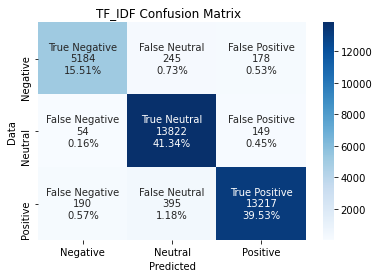

In [106]:
import seaborn as sns
group_names = ["True Negative","False Neutral","False Positive","False Negative","True Neutral","False Positive","False Negative","False Neutral","True Positive"]

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
ax= plt.subplot()
ax.set_title('TF_IDF Confusion Matrix  ');
sns.heatmap(cm, annot=labels,ax=ax, fmt='', cmap='Blues')

ax.xaxis.set_ticklabels(['Negative','Neutral', 'Positive']); ax.yaxis.set_ticklabels(['Negative','Neutral', 'Positive']);

plt.xlabel('Predicted')
plt.ylabel('Data')

In [107]:
target_names=['Negative','Neutral' ,'Positive']
Classification_report = classification_report(y_test,prediction, target_names=target_names)

print(Classification_report)

              precision    recall  f1-score   support

    Negative       0.96      0.92      0.94      5607
     Neutral       0.96      0.99      0.97     14025
    Positive       0.98      0.96      0.97     13802

    accuracy                           0.96     33434
   macro avg       0.96      0.96      0.96     33434
weighted avg       0.96      0.96      0.96     33434



In [95]:
print('ACCURACY',int(round(accuracy_score(y_test,prediction)*100)),'%')
print('Coefficient of determination: %.2f'
     % r2_score(y_test,prediction))

ACCURACY 96 %
Coefficient of determination: 0.87


In [96]:
from joblib import dump, load
import pickle
pickle.dump(text_f, open('tweets_tfidf.pkl','wb'))
model_tfidf = pickle.load(open('tweets_tfidf.pkl','rb'))

In [103]:
import numpy as np 
model_tfidf= load('tweets_tfidf.pkl') 
message='the corona virus is deadly'
data=[message]
vect = vectorizer.transform(data)
my_prediction = model1.predict(vect)
if (my_prediction[0]==2):
    print('Neutral')
elif ((my_prediction[0]==0)):
    print('Negative')
else:
    print('Positive')

Negative


In [108]:
def getAnalysis(score):
    if score>0:
        return 'Positive'
   
    else:
        
        return 'Negative'
tweets['Analysis2'] =tweets['Polarity'].apply(getAnalysis)
def transform(text):
    if (text=='Positive'):
        return 1

    else :
        return 0
tweets['label2']=tweets['Analysis2'].apply(transform)

<h1>LOGISTIC REGRESSION </h1>

In [112]:
from sklearn.linear_model import LogisticRegression
y=tweets['label2']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [ ]:
logmod=LogisticRegression()
logmod.fit(X_train,y_train)

In [120]:
print('ACCURACY',int(round(accuracy_score(y_test,prediction)*100)),'%')
print('Coefficient of determination: %.2f'
     % r2_score(y_test,prediction))

ACCURACY 97 %
Coefficient of determination: 0.86


              precision    recall  f1-score   support

    Negative       0.96      0.98      0.97     19604
    Positive       0.97      0.95      0.96     13830

    accuracy                           0.97     33434
   macro avg       0.97      0.96      0.96     33434
weighted avg       0.97      0.97      0.97     33434



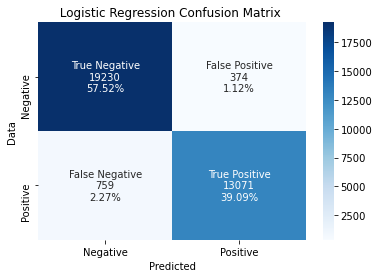

In [119]:
cm=confusion_matrix(y_test,prediction)

group_names = ["True Negative","False Positive","False Negative","True Positive"]

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax= plt.subplot()
ax.set_title(' Logistic Regression Confusion Matrix  ');
sns.heatmap(cm, annot=labels,ax=ax, fmt='', cmap='Blues')

ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive']);

plt.xlabel('Predicted')
plt.ylabel('Data')

target_names=['Negative', 'Positive']
Classification_report = classification_report(y_test,prediction, target_names=target_names)

print(Classification_report)

<h1> Convolution text classification with Keras  </h1>

In [ ]:

import tensorflow as tf
from tensorflow.keras.preprocessing import text,sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Embedding,Conv1D,GlobalMaxPooling1D,MaxPooling1D
from sklearn.model_selection import train_test_split

<h3>Data prep_ tokenize and pad text data </h3>

In [162]:

max_features=20000
max_text_length=400
x=tweets['clean_tweets']
#allow us to vectorize return each text by sequence of integers ,each integer be the index of token in dictionary
x_tokenizer=text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))
#text to numbers
x_tokenized=x_tokenizer.texts_to_sequences(x) 
x_train_val=sequence.pad_sequences(x_tokenized,maxlen=max_text_length)

<h3>Prepare embedding matrix with pre-trained Glove Embedding </h3>

In [155]:
import numpy as np
embedding_dim=100
embedding_index=dict()
f=open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:],dtype='float32')
    embedding_index[word]=coefs
    
        
f.close()
                         
print('found',len(embedding_index),'word vectors ') 
   

found 400000 word vectors 


In [236]:
x_tokenizer.word_index

{'covid': 1,
 'the': 2,
 'cases': 3,
 'amp': 4,
 'coronavirus': 5,
 'i': 6,
 'new': 7,
 'people': 8,
 'this': 9,
 '…': 10,
 'one': 11,
 'our': 12,
 'us': 13,
 'deaths': 14,
 'pandemic': 15,
 'today': 16,
 'we': 17,
 'world': 18,
 'hospital': 19,
 'day': 20,
 'rate': 21,
 'health': 22,
 'average': 23,
 'positivity': 24,
 'w…': 25,
 'nearly': 26,
 'need': 27,
 'a': 28,
 'rates': 29,
 'trump': 30,
 'please': 31,
 'india': 32,
 'vaccine': 33,
 'positive': 34,
 'see': 35,
 'icu': 36,
 'blood': 37,
 'many': 38,
 'caseload': 39,
 'like': 40,
 'downour': 41,
 'in': 42,
 'get': 43,
 'breaking': 44,
 'death': 45,
 'it’s': 46,
 'realdonaldtrump': 47,
 'million': 48,
 'covid…': 49,
 'last': 50,
 'total': 51,
 'want': 52,
 'number': 53,
 'but': 54,
 'yet': 55,
 'know': 56,
 'work': 57,
 'reported': 58,
 'testing': 59,
 'tests': 60,
 'if': 61,
 'school': 62,
 'retweet': 63,
 'help': 64,
 'mask': 65,
 'time': 66,
 'back': 67,
 'as': 68,
 'due': 69,
 'video': 70,
 'plasma': 71,
 'spread': 72,
 't…': 7

In [156]:
embedding_matrix=np.zeros((max_features,embedding_dim))
for word,index in x_tokenizer.word_index.items():
    if index >max_features -1 :
        break
    else:
        embedding_vector=embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix=embedding_vector
            

<h3> Create the embedding Layer </h3>

In [157]:
model=Sequential()
model.add(Embedding(max_features,embedding_dim, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                   trainable=False))
model.add(Dropout(0.2))

<h3>Build the model </h3>

In [158]:
filters=250
kernel_size=3
hidden_dims=250
model.add(Conv1D(filters,kernel_size,padding='valid'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,5,padding='valid',activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2000000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 250)         75250     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 250)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 250)         312750    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
____

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

<h3>Train Model </h3>

In [160]:
y=tweets['label2']
X_train,X_test,y_train,y_test=train_test_split(x_train_val,y,test_size=0.2)
batch_size=32
epochs=3

In [161]:
%%time
model.fit(X_train,y_train,batch_size=batch_size,epochs=3,validation_data=(X_test,y_test))

Train on 133736 samples, validate on 33434 samples
Epoch 1/3
133736/133736 [==============================] - 865s 6ms/sample - loss: 0.6688 - acc: 0.5862 - val_loss: 0.6643 - val_acc: 0.5910
Epoch 2/3
133736/133736 [==============================] - 849s 6ms/sample - loss: 0.6645 - acc: 0.5889 - val_loss: 0.6625 - val_acc: 0.5910
Epoch 3/3
133736/133736 [==============================] - 875s 7ms/sample - loss: 0.6639 - acc: 0.5884 - val_loss: 0.6615 - val_acc: 0.5910
Wall time: 43min 13s


In [174]:
score = model.evaluate(X_test, y_test)

16972/16972 [==============================] - 36s 2ms/sample - loss: 0.4816 - acc: 0.8120


<h3>Text Classification with LSTM </h3>

In [176]:
from keras.layers import LSTM,Dropout




In [185]:

from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.layers import Dropout,GlobalMaxPool1D
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D 


maxlen=max_text_length
inp = Input(shape=(maxlen, ))
embed_size = 128
x = Embedding(max_features, embedding_dim)(inp)
x = LSTM(128, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(90, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(60, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

#sparse_categorical_crossentropy

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 400)]             0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 400, 100)          2000000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 400, 128)          117248    
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 128)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 90)                11610     
_________________________________________________________________
dropout_15 (Dropout)         (None, 90)                0   

In [174]:

from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.layers import Dropout,GlobalMaxPool1D
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D 


maxlen=max_text_length
inp = Input(shape=(maxlen, ))
embed_size = 128
x = Embedding(max_features, embedding_dim)(inp)
x = LSTM(128, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.2)(x)
x = Dense(90, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(60, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

#sparse_categorical_crossentropy

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 400, 100)          2000000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 400, 128)          117248    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 90)                11610     
_________________________________________________________________
dropout_6 (Dropout)          (None, 90)                0   

In [175]:
y=tweets['label2']
X_train,X_test,y_train,y_test=train_test_split(x_train_val,y,test_size=0.2)
batch_size=32
epochs=3

<h5>Train on 67888 samples, validate on 16972 samples</h5>

In [187]:
%%time
history=model.fit(X_train,y_train,batch_size=batch_size,epochs=3,validation_data=(X_test,y_test))

Train on 67888 samples, validate on 16972 samples
Epoch 1/3
67888/67888 [==============================] - 3697s 54ms/sample - loss: 0.1491 - acc: 0.9477 - val_loss: 0.0831 - val_acc: 0.9734
Epoch 2/3
67888/67888 [==============================] - 2701s 40ms/sample - loss: 0.0558 - acc: 0.9820 - val_loss: 0.0894 - val_acc: 0.9729
Epoch 3/3
67888/67888 [==============================] - 1806s 27ms/sample - loss: 0.0266 - acc: 0.9914 - val_loss: 0.1074 - val_acc: 0.9722
Wall time: 2h 16min 49s


<h5>Train on 133736 samples, validate on 33434 samples</h5>

In [176]:
%%time
history=model.fit(X_train,y_train,batch_size=batch_size,epochs=3,validation_data=(X_test,y_test))

Train on 133736 samples, validate on 33434 samples
Epoch 1/3
133736/133736 [==============================] - 3163s 24ms/sample - loss: 0.1697 - acc: 0.9400 - val_loss: 0.1052 - val_acc: 0.9673
Epoch 2/3
133736/133736 [==============================] - 3030s 23ms/sample - loss: 0.0773 - acc: 0.9754 - val_loss: 0.1022 - val_acc: 0.9712
Epoch 3/3
133736/133736 [==============================] - 6006s 45ms/sample - loss: 0.0476 - acc: 0.9839 - val_loss: 0.1142 - val_acc: 0.9690
Wall time: 3h 23min 42s


In [167]:
score ,accuracy= model.evaluate(X_test, y_test)

33434/33434 [==============================] - 148s 4ms/sample - loss: 0.1170 - acc: 0.9696


In [188]:
score ,accuracy= model.evaluate(X_test, y_test)

16972/16972 [==============================] - 91s 5ms/sample - loss: 0.1074 - acc: 0.97220s - loss: 0.1072 - acc: 0


In [189]:
print("Test Score:", score)
print("Test Accuracy:", accuracy)


Test Score: 0.10744893431647928
Test Accuracy: 0.9721895


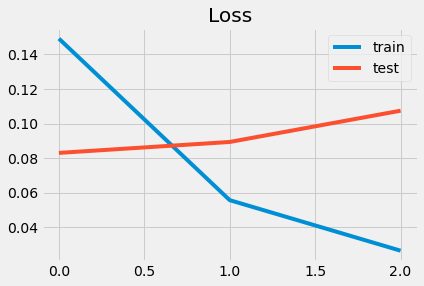

In [191]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

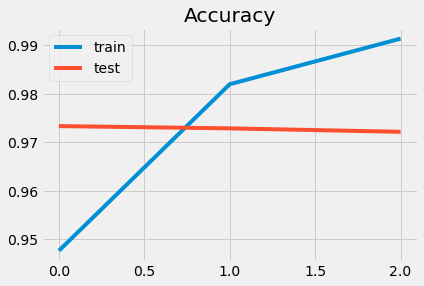

In [192]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

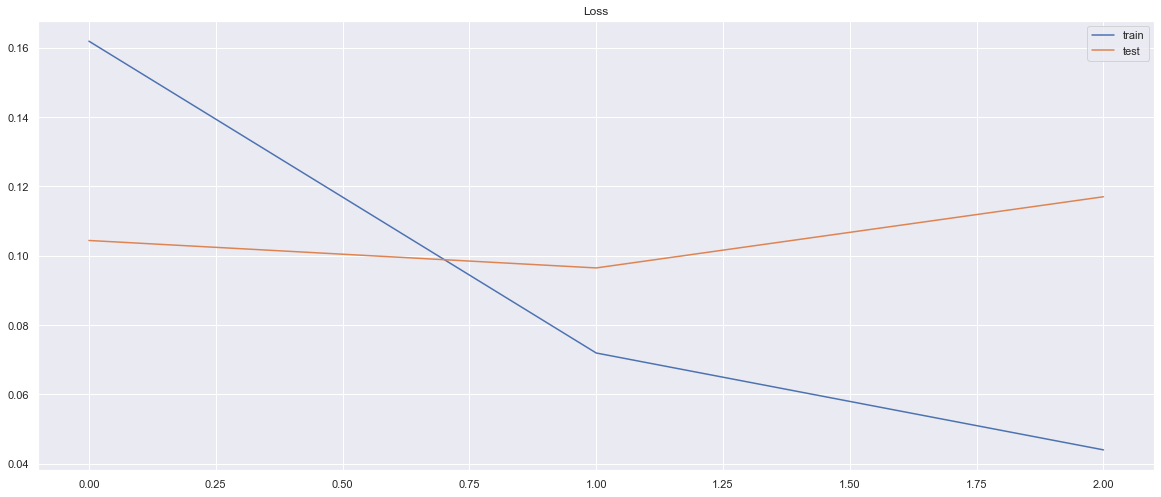

In [168]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

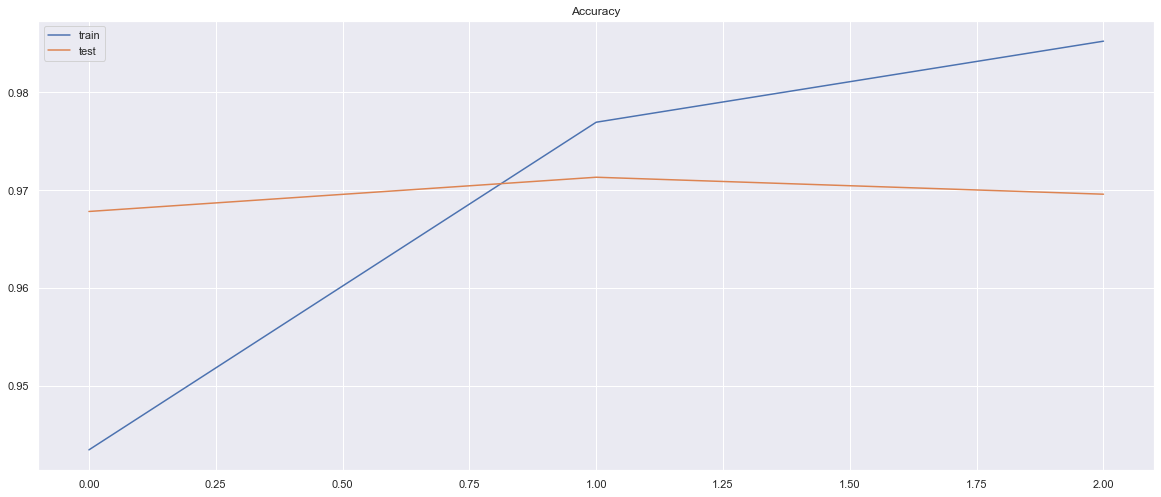

In [169]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

<h2> Z. E</h2>